# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'netifier-kmeans'
epochs = 10
batch_size = 32
sequence_length = 96

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/doctors-answer-text-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

train_labels = train_data.columns[2:8]
val_labels = val_data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[train_labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


# BUILD DATASET & DATALOADERS

In [8]:
class DoctorAnswerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=256, num_workers=4):
    train_dataset = DoctorAnswerDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = DoctorAnswerDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [10]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [11]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [12]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p2',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [13]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [14]:
def kmeans_clustering_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = DoctorAnswerDataset(X_pool, np.zeros((len(X_pool), 6)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    model.eval()
    start_time = time.time()
    embeddings = []
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)
    collected_indices = set()  # Initialize set to store selected indices

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        num_of_candidates = len(embeddings[:math.ceil(0.1 * len(embeddings))])
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    
        # Determine number of clusters
        if num_of_candidates <= n_clusters and n_clusters < nearest_cp - current_train_size:
            n_clusters = n_clusters
        elif num_of_candidates > n_clusters and num_of_candidates < nearest_cp - current_train_size:
            n_clusters = num_of_candidates
        else:
            arrived_at_cp = True
            n_clusters = nearest_cp - current_train_size
            
        kmeans=KMeans(n_clusters=n_clusters, n_init=1)
        kmeans.fit(embeddings)
    
        if current_train_size > checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                '1-FR': [y_train[i][0] for i in temp],
                '2-GI': [y_train[i][1] for i in temp],
                '3-PI': [y_train[i][2] for i in temp],
                '4-DM': [y_train[i][3] for i in temp],
                '5-EDTRB': [y_train[i][4] for i in temp],
                '6-RE': [y_train[i][5] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Samples above threshold:", num_of_candidates)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]  # Indices of samples in the current cluster
                
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances to the cluster center
                cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
                closest_sample_index = cluster_indices[np.argmin(cluster_distances)]  # Closest sample index
                collected_indices.add(closest_sample_index)

            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'pornografi': [y_train[i][0] for i in temp],
                    'sara': [y_train[i][1] for i in temp],
                    'radikalisme': [y_train[i][2] for i in temp],
                    'pencemaran_nama_baik': [y_train[i][3] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Samples above threshold:", num_of_candidates)
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

# MAIN LOOP

In [15]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i)
        notebook_launcher(kmeans_clustering_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [16]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7417, Accuracy: 0.8438, F1 Micro: 0.8861, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6068, Accuracy: 0.931, F1 Micro: 0.949, F1 Macro: 0.6633
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5321, Accuracy: 0.9609, F1 Micro: 0.9705, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4626, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3907, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3555, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3257, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2884, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7366, Accuracy: 0.8464, F1 Micro: 0.888, F1 Macro: 0.6516
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6044, Accuracy: 0.9323, F1 Micro: 0.95, F1 Macro: 0.6639
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5471, Accuracy: 0.9635, F1 Micro: 0.9724, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4709, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4143, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3651, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3201, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3141, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6726, Accuracy: 0.9258, F1 Micro: 0.9453, F1 Macro: 0.6621
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5123, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3945, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3196, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2764, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2371, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2312, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2015, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6746, Accuracy: 0.9362, F1 Micro: 0.9527, F1 Macro: 0.665
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5099, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3983, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3312, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2931, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.22, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2058, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2067, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6337, Accuracy: 0.9609, F1 Micro: 0.9705, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4269, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3138, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2496, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2378, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1986, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1997, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1775, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6297, Accuracy: 0.9609, F1 Micro: 0.9705, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4165, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3049, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2522, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2332, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1879, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1844, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2079, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5919, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3565, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2685, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.214, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2143, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1815, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1894, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1497, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5911, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3671, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2716, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2321, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1836, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1838, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1768, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1752, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5935, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3595, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2618, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2191, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1946, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1666, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1605, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1635, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5926, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3627, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2569, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2248, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1891, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1921, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1688, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1702, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.562, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3139, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2254, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2029, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1769, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1612, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1716, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1765, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5593, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3284, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2422, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1937, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1718, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1561, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1698, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1595, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5602, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3252, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2381, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2069, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1935, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1613, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.181, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1603, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5514, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3247, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2368, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1982, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.186, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1677, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1689, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1625, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.561, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3223, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2403, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.211, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2006, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1582, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.175, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1735, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5536, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3049, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2268, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2061, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2032, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1899, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1779, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1755, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5323, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2964, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2333, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1783, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1956, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1782, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1698, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1712, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5293, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2922, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2098, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1843, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1766, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1832, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1714, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1737, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5218, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2922, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2129, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1926, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1896, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1733, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1718, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1606, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5233, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2853, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2061, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1967, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1827, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1757, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1594, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1691, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.527, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2921, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2167, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2002, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1797, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1631, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.164, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1677, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5293, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2942, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2068, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1822, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1699, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1582, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1523, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1554, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5013, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2547, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2135, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1825, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1576, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1692, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1671, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1492, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5051, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.258, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.192, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1925, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1844, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.174, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1625, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1533, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

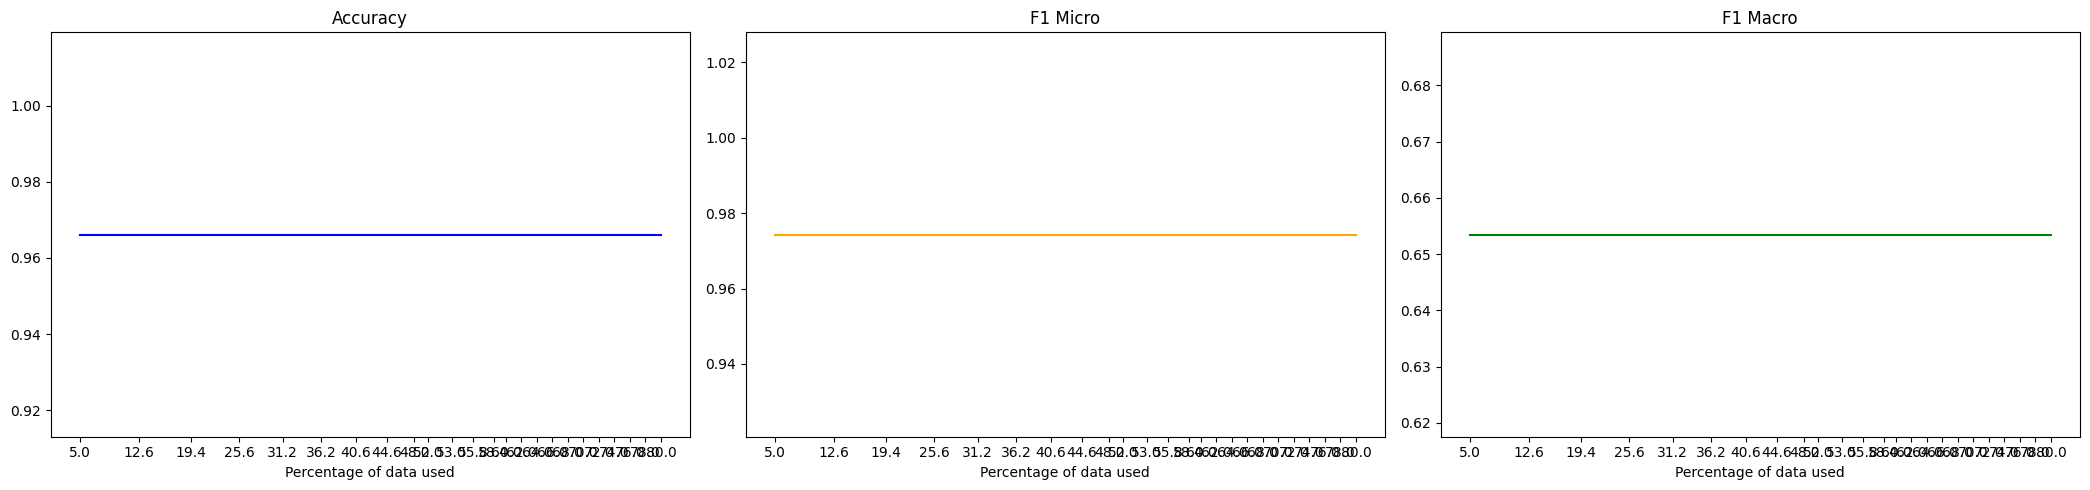

In [17]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7759, Accuracy: 0.6276, F1 Micro: 0.7129, F1 Macro: 0.4886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6568, Accuracy: 0.9193, F1 Micro: 0.9405, F1 Macro: 0.6604
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5443, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4694, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3976, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3515, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.312, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2775, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7696, Accuracy: 0.6289, F1 Micro: 0.7141, F1 Macro: 0.4893
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6583, Accuracy: 0.9062, F1 Micro: 0.9306, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5356, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4493, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3957, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3357, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3231, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2782, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7092, Accuracy: 0.8867, F1 Micro: 0.9174, F1 Macro: 0.6519
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4992, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3865, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3085, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2592, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2431, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2162, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1895, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7041, Accuracy: 0.8815, F1 Micro: 0.9134, F1 Macro: 0.6497
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5094, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3663, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3014, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2584, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2245, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2006, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2178, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6554, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4097, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3093, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2478, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2307, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2092, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2037, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1651, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6545, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4116, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3018, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.235, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2196, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2063, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.194, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1853, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.604, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.343, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2569, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2156, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1984, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2018, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1901, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1652, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6039, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3462, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2569, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2173, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2018, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1862, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1666, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1968, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.604, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3459, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2513, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1971, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1963, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1865, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.162, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1721, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6014, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3433, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2649, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2121, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1994, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1834, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1687, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1793, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5622, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2987, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2189, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2077, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2058, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1778, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1621, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1505, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5618, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3117, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2223, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.21, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1875, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.188, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1662, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1809, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5602, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3029, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2159, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1888, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1942, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1695, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1702, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1452, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.572, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3076, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2293, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.185, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1807, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1772, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1903, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1599, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.564, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3033, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2451, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1996, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1792, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1788, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1856, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1678, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5688, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3008, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2381, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1991, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.185, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1498, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1662, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1747, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.526, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2763, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.222, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1734, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1663, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1743, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1627, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1816, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5331, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2784, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2112, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.181, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1847, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1755, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1715, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1823, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5288, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.279, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2081, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1979, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1846, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1647, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1569, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1781, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5299, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2766, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2089, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1818, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1796, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1673, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1694, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1543, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5362, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2693, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1943, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.179, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1733, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1533, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.154, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5341, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2696, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.207, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1887, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1707, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1535, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1745, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1589, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5042, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2515, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2053, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1777, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1738, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1653, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1719, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1631, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5047, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2584, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2025, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1782, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1687, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1738, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1584, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1468, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

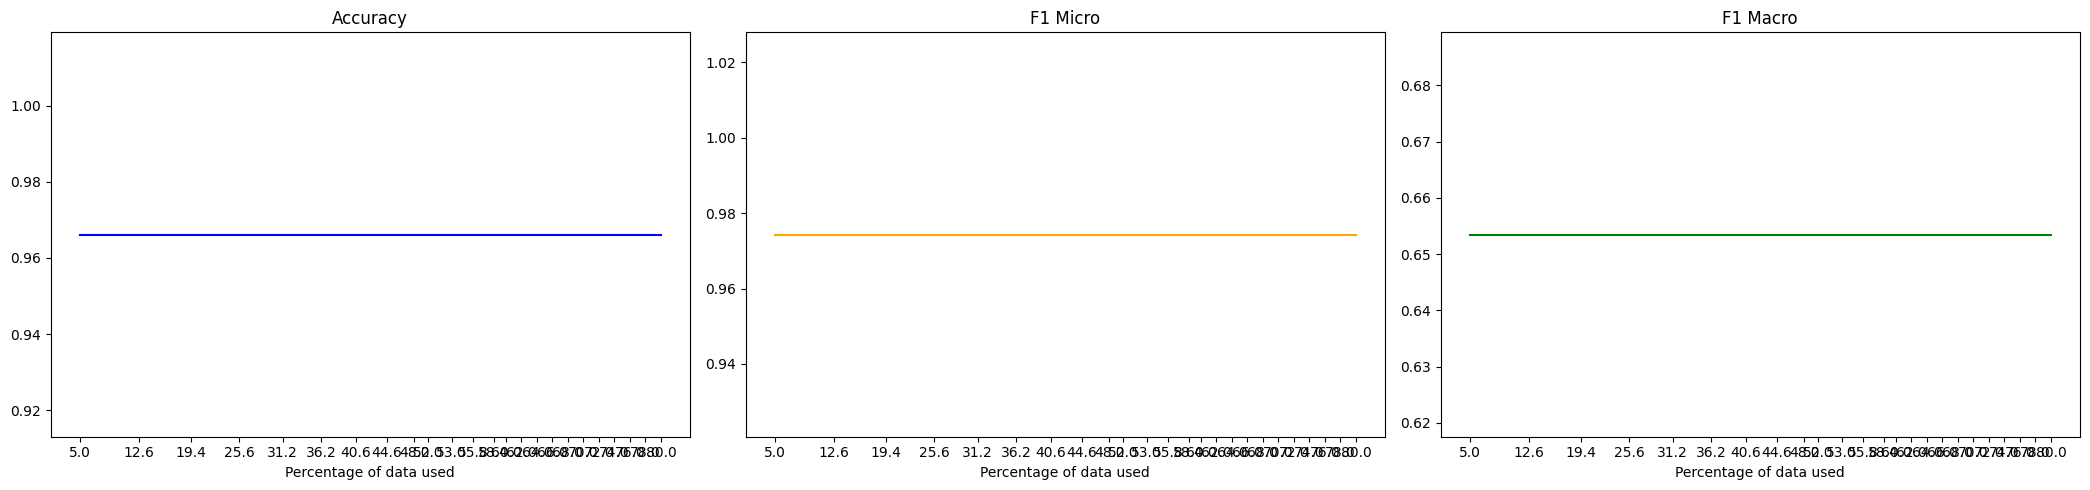

In [18]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6708, Accuracy: 0.832, F1 Micro: 0.8709, F1 Macro: 0.6144
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5673, Accuracy: 0.9609, F1 Micro: 0.9702, F1 Macro: 0.6503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4855, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4136, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3704, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.322, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2931, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.267, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.686, Accuracy: 0.8385, F1 Micro: 0.8787, F1 Macro: 0.6279
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.56, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4876, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4097, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3715, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3283, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2898, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2489, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6267, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4612, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3582, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2779, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2515, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.222, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2062, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1862, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6215, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4633, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3505, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.285, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2521, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2477, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2246, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2256, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5823, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3802, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.286, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2391, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2192, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1804, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1895, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1899, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5854, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3813, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.285, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2401, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1916, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2002, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1874, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1666, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5435, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3167, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2204, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1851, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1894, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1793, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1677, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1734, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5438, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3229, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2483, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1954, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1919, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1877, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1674, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1691, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5452, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3189, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2426, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2097, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1932, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1686, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1564, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1669, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5449, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3263, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2344, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2141, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1707, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1805, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1762, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1408, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5116, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2896, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2135, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.181, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1642, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1724, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1579, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1304, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5082, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.288, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2303, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1824, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1683, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.159, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.175, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.144, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5073, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2776, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2216, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1967, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1737, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1621, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1428, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1445, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5131, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2937, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2232, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.194, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1785, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1596, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1661, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.148, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.511, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2842, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2338, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1836, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1862, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1577, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1686, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1617, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5076, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.29, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2269, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1816, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.201, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1813, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1553, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1714, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4828, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2657, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.22, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1743, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1728, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1811, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1391, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1403, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4766, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2675, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2122, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1898, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1674, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.158, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.167, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1775, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4883, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2608, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1936, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.181, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1663, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1635, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1703, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1506, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4847, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2695, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2032, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1979, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1736, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1778, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1611, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1504, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4856, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2629, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2186, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1887, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1874, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1746, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1533, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1573, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.479, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2743, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2076, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1944, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1816, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1695, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1454, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1613, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4612, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.24, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2091, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1734, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1638, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1789, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1644, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1488, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4629, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.247, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1999, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1793, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1841, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1656, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1571, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1507, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

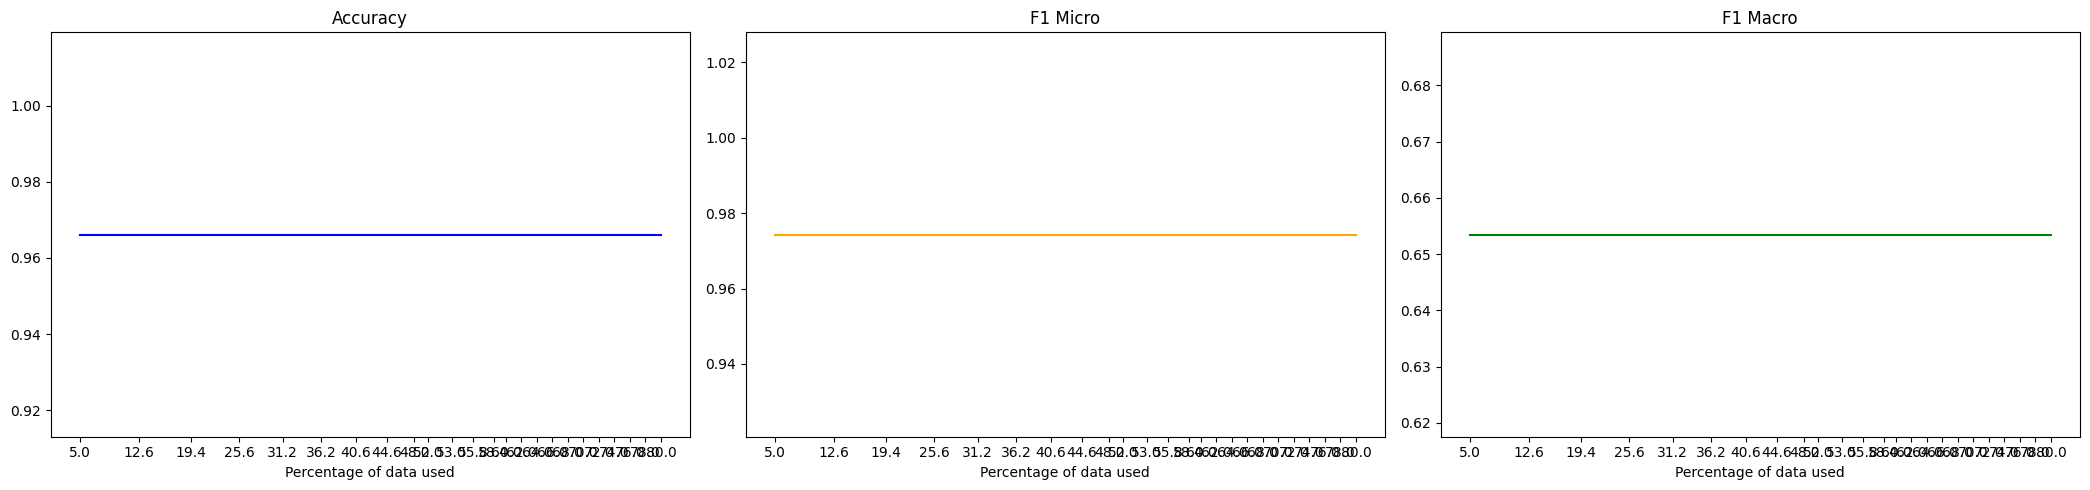

In [19]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6467, Accuracy: 0.9648, F1 Micro: 0.9733, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5398, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4478, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3936, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3431, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.31, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2886, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2554, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6463, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.542, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4515, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3924, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3384, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3114, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2849, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2595, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5964, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.417, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.328, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2697, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2148, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2305, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2127, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1892, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5996, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4235, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3281, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2709, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2381, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2356, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2106, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2121, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5444, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3453, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2554, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2228, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2137, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1883, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1894, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1858, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5554, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3557, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2637, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2313, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2032, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2002, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1721, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1723, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5118, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3027, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.228, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1932, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1905, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1947, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1819, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1693, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5162, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3068, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2385, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2201, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1949, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1925, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1755, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1841, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5149, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3066, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.239, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2038, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1843, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1932, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1783, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.181, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5091, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3012, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2452, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1957, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1873, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1687, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1849, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1498, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.478, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2761, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2102, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1956, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1843, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.17, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1721, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1415, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4757, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2745, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2197, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1768, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1814, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1783, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1791, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1746, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4776, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2756, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2172, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1874, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1852, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1944, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1736, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1636, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.478, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2788, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2369, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1741, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1731, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1675, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1634, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.48, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2708, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.207, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1763, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1823, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1759, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.174, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1518, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4779, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2709, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2055, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1839, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1786, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1747, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1591, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.168, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4539, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2474, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2047, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1705, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1846, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1554, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1558, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1637, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4475, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2452, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2076, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1893, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1786, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1651, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1827, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1597, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4521, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.26, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1949, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1981, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1857, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1814, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1682, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1436, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4556, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2538, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1996, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1961, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1845, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1548, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1511, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.163, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4493, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2428, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1952, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.18, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1713, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1574, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1759, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1747, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4518, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2549, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1965, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1833, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.175, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1745, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1639, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1632, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4324, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2353, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1945, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1756, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1573, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1571, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1629, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4303, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2317, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1936, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1632, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1643, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1675, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1606, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

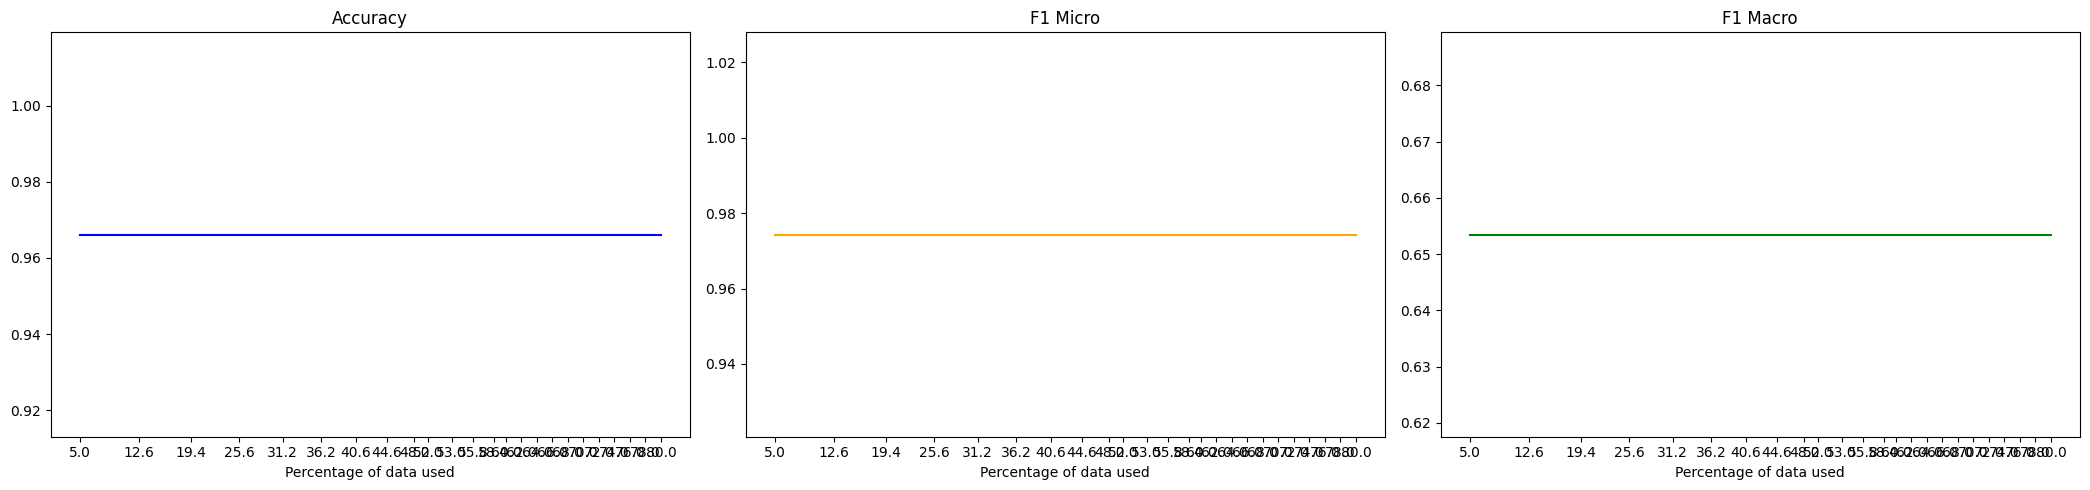

In [20]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7246, Accuracy: 0.8529, F1 Micro: 0.8964, F1 Macro: 0.6595
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5992, Accuracy: 0.9492, F1 Micro: 0.962, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5024, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4281, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3713, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3311, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3032, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2839, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7312, Accuracy: 0.8698, F1 Micro: 0.906, F1 Macro: 0.6499
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6036, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4984, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4157, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3621, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3463, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2781, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.281, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6591, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4573, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3528, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2692, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2438, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2302, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2184, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.176, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6611, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4601, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3364, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2718, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2501, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2119, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2179, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2037, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6068, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3762, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2623, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2376, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1968, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1832, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1989, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1672, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.603, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3699, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2695, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2335, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2022, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1829, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1893, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1937, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5671, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3206, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2476, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1997, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1751, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1572, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1938, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1745, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5629, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3241, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2359, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2072, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1852, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1821, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.174, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1821, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.567, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3292, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2385, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2133, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2025, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1874, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.175, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1804, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5585, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3294, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.224, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2059, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1896, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1792, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1627, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1762, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5149, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2726, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2112, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1852, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1916, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1776, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1582, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1528, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5224, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.283, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2057, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2018, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1761, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1557, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1674, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1633, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5146, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2844, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2204, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1995, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1813, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1806, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1705, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1628, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5202, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2735, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2172, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1978, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1831, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1671, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1788, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1523, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5268, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2772, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2149, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1903, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1777, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1747, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1776, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1633, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5302, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2762, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2199, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2034, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1949, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1752, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1581, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1715, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4881, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2445, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2012, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2005, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1777, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1817, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1799, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1432, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4864, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2495, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1945, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1744, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1616, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.19, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1566, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1552, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4912, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2526, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.199, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1916, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1746, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1739, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1628, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1502, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4881, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2481, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2021, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1819, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1737, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.154, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1482, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1689, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.494, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2561, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1927, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1807, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1695, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1649, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1781, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1489, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4892, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2404, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1883, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1716, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1608, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.175, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1723, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1526, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.463, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2284, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2042, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1659, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1694, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1655, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1416, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4644, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2263, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1812, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1622, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1763, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1717, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1473, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1616, Accuracy: 0.9661, F1 Micro: 0.9743, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

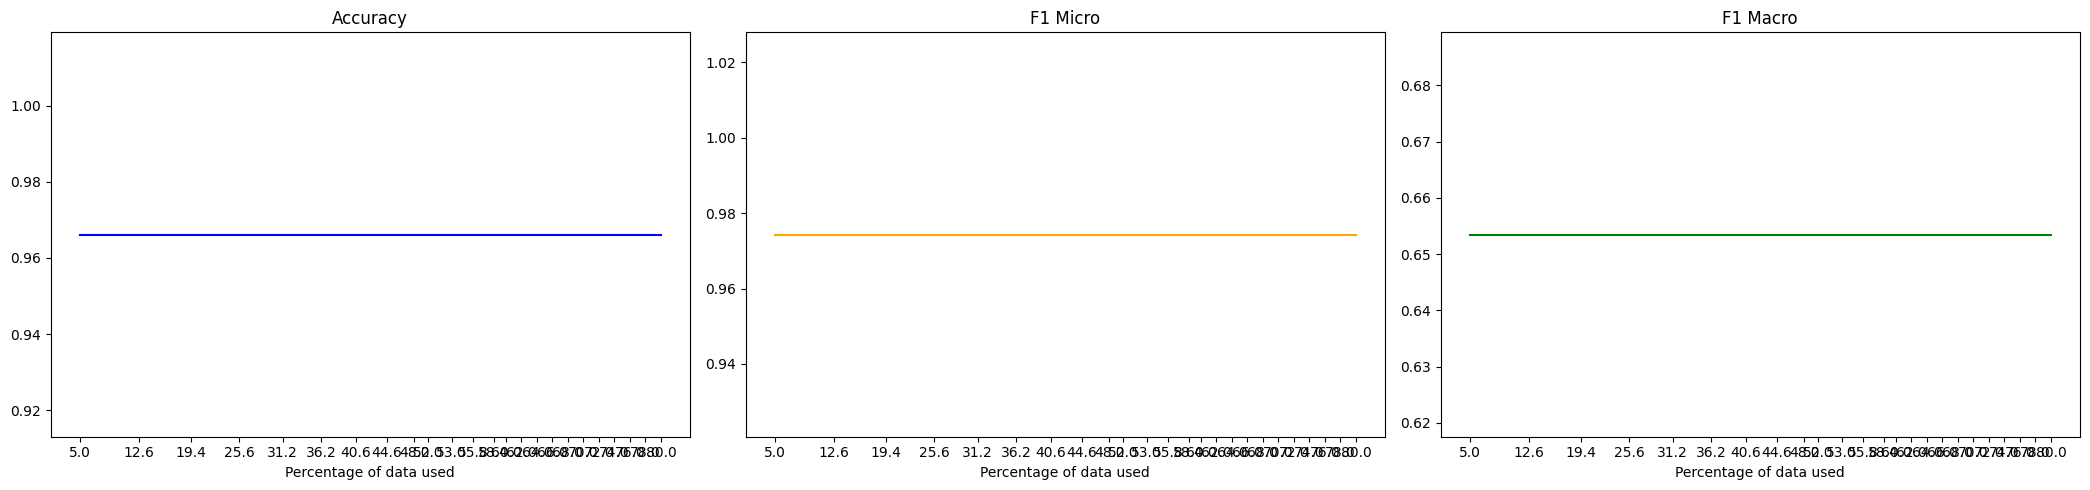

In [21]:
active_learning(seeds[4], 4)